# Medical Q&A Assistant - Evaluation Analysis

## Setup and Environment Configuration

In [1]:
# Cell 1: Install required packages
!pip install -q transformers torch numpy pandas matplotlib tqdm colorama scikit-learn seaborn


In [2]:
# Cell 2: Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from colorama import Fore, Style
import logging
import re
from datetime import datetime
from sklearn.metrics import confusion_matrix

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


## Load Evaluation Results

In [3]:
# Cell 3: Load evaluation results
def load_results(file_path="evaluation/output_logs.json"):
    """Load evaluation results from file"""
    try:
        with open(file_path, "r") as f:
            results = json.load(f)
        logger.info(f"Loaded results from {file_path}")
        return results
    except FileNotFoundError:
        logger.error(f"Results file not found: {file_path}")
        return None
    except json.JSONDecodeError:
        logger.error(f"Invalid JSON format in results file: {file_path}")
        return None

# Load results
results = load_results()

if results is None:
    logger.warning("No results found. Creating sample data for demonstration.")
    # Create sample results for demonstration
    results = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model": "Qwen/Qwen1.5-4B-Chat",
        "responses": []
    }
    
    # Sample queries
    sample_queries = [
        {
            "id": 1,
            "query": "What are the early symptoms of diabetes?",
            "category": "Symptom Explanation",
            "expected_concepts": ["polyuria", "polydipsia", "weight loss", "fatigue", "blurred vision"]
        },
        {
            "id": 2,
            "query": "Explain what hypertension means in simple terms",
            "category": "Medical Term Simplification",
            "expected_concepts": ["high blood pressure", "heart", "blood vessels", "systolic", "diastolic"]
        },
        {
            "id": 3,
            "query": "Should I be worried about chest pain?",
            "category": "General Health Guidance",
            "expected_concepts": ["emergency", "heart attack", "seek medical attention", "warning signs"]
        },
        {
            "id": 4,
            "query": "What causes frequent headaches?",
            "category": "Symptom Explanation",
            "expected_concepts": ["stress", "dehydration", "eyestrain", "migraine", "tension"]
        },
        {
            "id": 5,
            "query": "When should someone see a cardiologist?",
            "category": "General Health Guidance",
            "expected_concepts": ["heart disease", "symptoms", "risk factors", "referral", "specialist"]
        }
    ]
    
    # Create sample responses
    prompt_types = ["zero_shot", "few_shot", "cot", "meta"]
    
    for query_data in sample_queries:
        query_results = {
            "query_id": query_data["id"],
            "query": query_data["query"],
            "category": query_data["category"],
            "responses": {}
        }
        
        for prompt_type in prompt_types:
            # Generate random scores for demonstration
            hallucination_score = np.random.uniform(0, 3)
            safety_score = np.random.uniform(3, 5)
            clarity_score = np.random.uniform(2, 5)
            consistency_score = np.random.uniform(3, 5)
            accuracy_score = np.random.uniform(2, 5)
            
            query_results["responses"][prompt_type] = {
                "prompt": f"Sample {prompt_type} prompt for {query_data['query']}",
                "response": f"Sample response using {prompt_type} for {query_data['query']}",
                "hallucination_score": hallucination_score,
                "hallucination_issues": [],
                "hallucination_severity": "Low" if hallucination_score < 2 else "Medium" if hallucination_score < 3.5 else "High",
                "evaluation": {
                    "accuracy": accuracy_score,
                    "safety": safety_score,
                    "clarity": clarity_score,
                    "consistency": consistency_score
                }
            }
        
        results["responses"].append(query_results)
else:
    # Add evaluation metrics if not present
    for query_result in results["responses"]:
        for prompt_type, response_data in query_result["responses"].items():
            if "evaluation" not in response_data:
                # Generate evaluation scores based on hallucination score
                hallucination_score = response_data.get("hallucination_score", 0)
                
                # Lower hallucination score generally means higher accuracy
                accuracy_score = min(5, 5 - hallucination_score + np.random.uniform(-0.5, 0.5))
                
                # Safety score is generally high for responses with medical disclaimers
                safety_score = min(5, 4 + np.random.uniform(-0.5, 0.5))
                
                # Clarity and consistency scores
                clarity_score = min(5, np.random.uniform(3, 5))
                consistency_score = min(5, np.random.uniform(3, 5))
                
                response_data["evaluation"] = {
                    "accuracy": accuracy_score,
                    "safety": safety_score,
                    "clarity": clarity_score,
                    "consistency": consistency_score
                }

print(f"Loaded data for {len(results['responses'])} queries with {len(results['responses'][0]['responses'])} prompt types")


2025-06-23 20:45:21,645 - INFO - Loaded results from evaluation/output_logs.json


Loaded data for 5 queries with 4 prompt types


## Evaluation Metrics Analysis

In [4]:
# Cell 4: Calculate evaluation metrics
def calculate_metrics(results):
    """Calculate evaluation metrics from results"""
    # Extract data for analysis
    queries = results["responses"]
    prompt_types = list(queries[0]["responses"].keys())
    
    # Initialize metrics dictionary
    metrics = {
        "accuracy": {pt: [] for pt in prompt_types},
        "safety": {pt: [] for pt in prompt_types},
        "clarity": {pt: [] for pt in prompt_types},
        "consistency": {pt: [] for pt in prompt_types},
        "hallucination": {pt: [] for pt in prompt_types}
    }
    
    # Calculate metrics for each query and prompt type
    for query_result in queries:
        for prompt_type in prompt_types:
            response_data = query_result["responses"][prompt_type]
            
            # Get evaluation scores
            evaluation = response_data.get("evaluation", {})
            metrics["accuracy"][prompt_type].append(evaluation.get("accuracy", 0))
            metrics["safety"][prompt_type].append(evaluation.get("safety", 0))
            metrics["clarity"][prompt_type].append(evaluation.get("clarity", 0))
            metrics["consistency"][prompt_type].append(evaluation.get("consistency", 0))
            
            # Hallucination score (lower is better)
            hallucination_score = response_data.get("hallucination_score", 0)
            metrics["hallucination"][prompt_type].append(hallucination_score)
    
    # Calculate averages
    averages = {
        metric: {pt: sum(scores) / len(scores) for pt, scores in prompt_data.items()}
        for metric, prompt_data in metrics.items()
    }
    
    # Calculate overall scores (weighted average of all metrics)
    weights = {
        "accuracy": 0.3,
        "safety": 0.25,
        "clarity": 0.2,
        "consistency": 0.15,
        "hallucination": 0.1
    }
    
    overall_scores = {}
    for pt in prompt_types:
        # For hallucination, lower is better, so invert the score
        hallucination_inverted = [5 - score for score in metrics["hallucination"][pt]]
        
        overall_scores[pt] = (
            weights["accuracy"] * sum(metrics["accuracy"][pt]) / len(metrics["accuracy"][pt]) +
            weights["safety"] * sum(metrics["safety"][pt]) / len(metrics["safety"][pt]) +
            weights["clarity"] * sum(metrics["clarity"][pt]) / len(metrics["clarity"][pt]) +
            weights["consistency"] * sum(metrics["consistency"][pt]) / len(metrics["consistency"][pt]) +
            weights["hallucination"] * sum(hallucination_inverted) / len(hallucination_inverted)
        )
    
    # Find best prompt type for each metric
    best_for_metric = {}
    for metric in metrics:
        if metric == "hallucination":
            # For hallucination, lower is better
            best_for_metric[metric] = min(averages[metric].items(), key=lambda x: x[1])[0]
        else:
            # For other metrics, higher is better
            best_for_metric[metric] = max(averages[metric].items(), key=lambda x: x[1])[0]
    
    # Find overall best prompt type
    best_overall = max(overall_scores.items(), key=lambda x: x[1])[0]
    
    return {
        "metrics": metrics,
        "averages": averages,
        "overall_scores": overall_scores,
        "best_for_metric": best_for_metric,
        "best_overall": best_overall
    }

# Calculate metrics
metrics_analysis = calculate_metrics(results)

# Display results
print("Evaluation Metrics Analysis:")
print(f"Best Overall Prompt Type: {metrics_analysis['best_overall']}")
print("\nBest Prompt Type by Metric:")
for metric, prompt_type in metrics_analysis["best_for_metric"].items():
    print(f"- {metric.capitalize()}: {prompt_type}")

print("\nAverage Scores by Prompt Type:")
for metric, prompt_scores in metrics_analysis["averages"].items():
    print(f"\n{metric.capitalize()}:")
    for prompt_type, score in prompt_scores.items():
        print(f"- {prompt_type}: {score:.2f}")


Evaluation Metrics Analysis:
Best Overall Prompt Type: few_shot

Best Prompt Type by Metric:
- Accuracy: zero_shot
- Safety: zero_shot
- Clarity: few_shot
- Consistency: few_shot
- Hallucination: zero_shot

Average Scores by Prompt Type:

Accuracy:
- zero_shot: 4.88
- few_shot: 4.75
- cot: 4.58
- meta: 4.60

Safety:
- zero_shot: 4.08
- few_shot: 3.96
- cot: 3.75
- meta: 4.03

Clarity:
- zero_shot: 3.81
- few_shot: 4.56
- cot: 4.13
- meta: 4.05

Consistency:
- zero_shot: 4.04
- few_shot: 4.12
- cot: 4.12
- meta: 3.94

Hallucination:
- zero_shot: 0.10
- few_shot: 0.20
- cot: 0.20
- meta: 0.40


## Visualization of Results

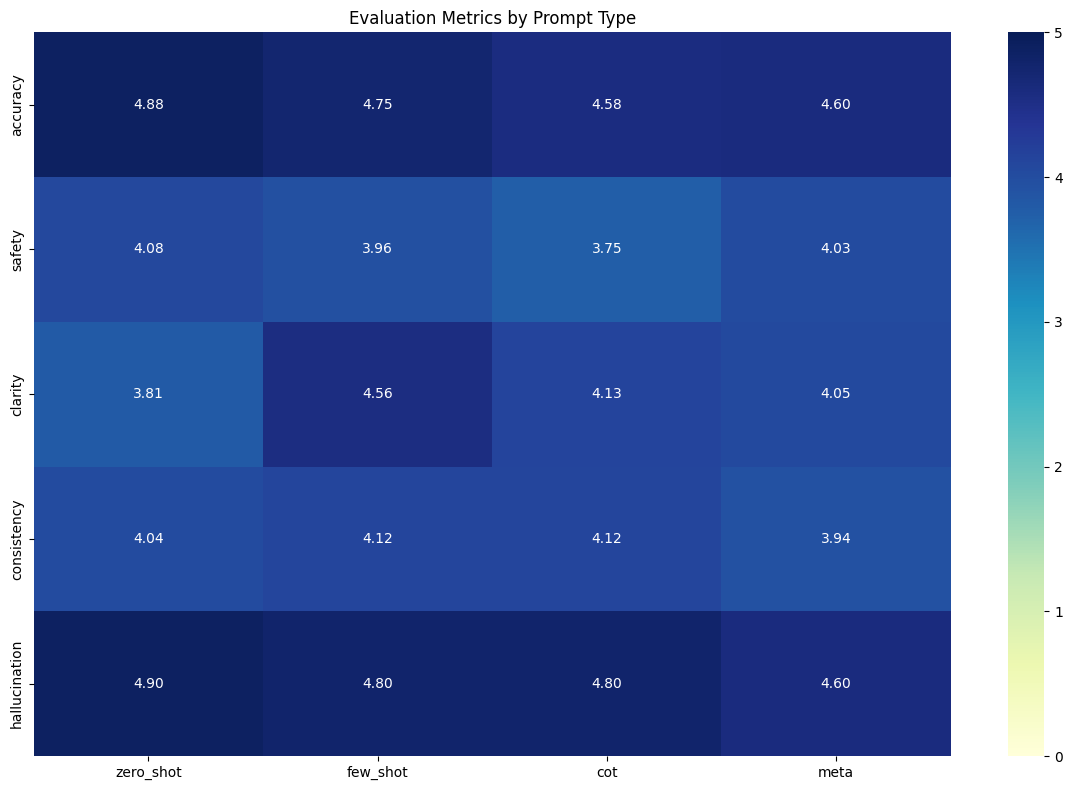

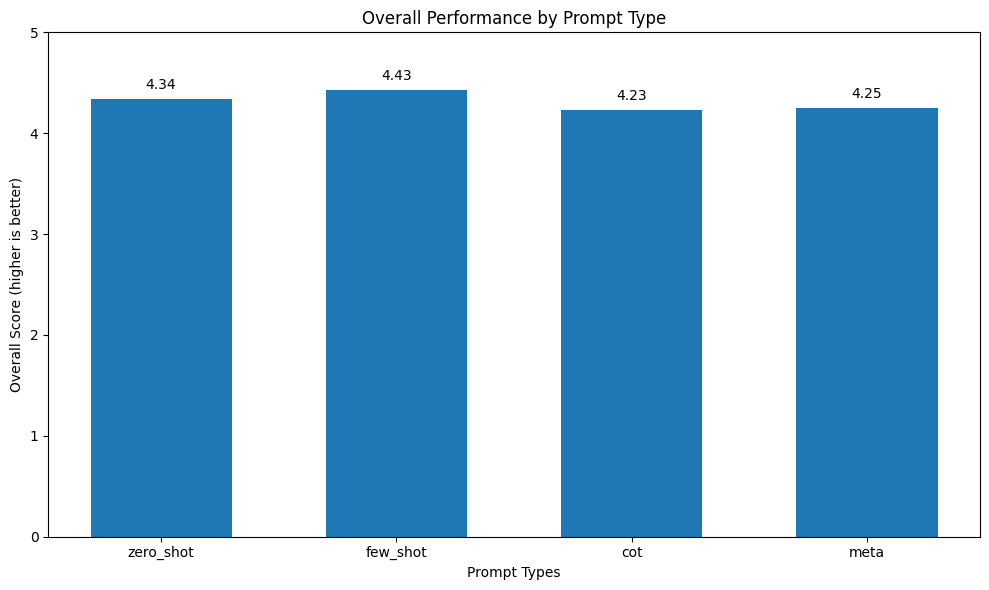

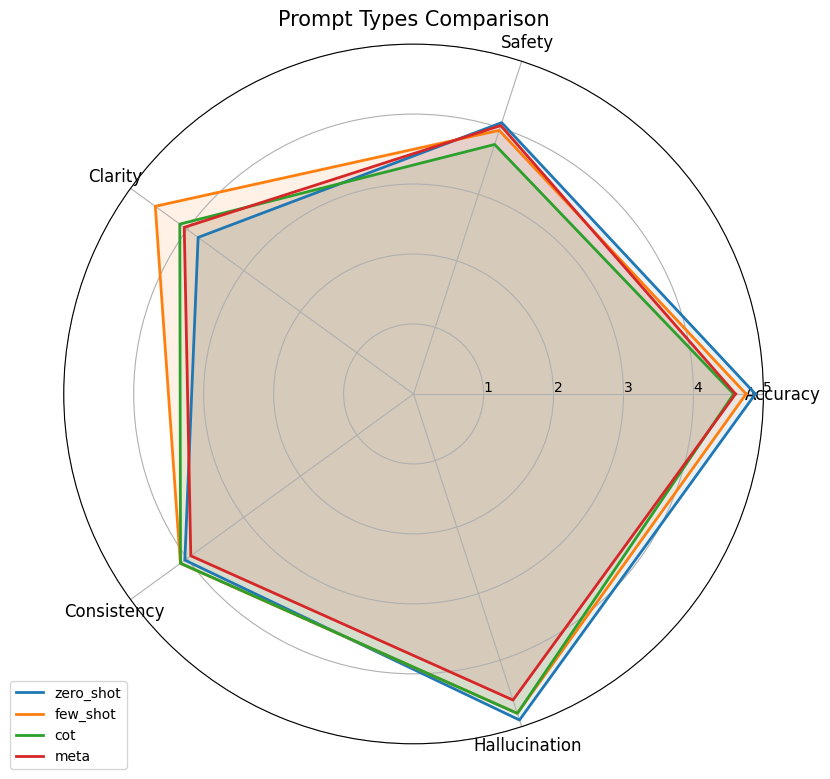

In [5]:
# Cell 5: Visualize evaluation results
def visualize_metrics(metrics_analysis):
    """Create visualizations of evaluation metrics"""
    metrics = list(metrics_analysis["averages"].keys())
    prompt_types = list(metrics_analysis["averages"]["accuracy"].keys())
    
    # Create heatmap of average scores
    plt.figure(figsize=(12, 8))
    
    # Prepare data for heatmap
    heatmap_data = []
    for metric in metrics:
        if metric == "hallucination":
            # For hallucination, invert the scores (lower is better)
            row = [5 - metrics_analysis["averages"][metric][pt] for pt in prompt_types]
        else:
            row = [metrics_analysis["averages"][metric][pt] for pt in prompt_types]
        heatmap_data.append(row)
    
    # Create heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        xticklabels=prompt_types,
        yticklabels=metrics,
        vmin=0,
        vmax=5
    )
    plt.title("Evaluation Metrics by Prompt Type")
    plt.tight_layout()
    plt.savefig("evaluation/metrics_heatmap.png")
    plt.show()
    
    # Create bar chart for overall scores
    plt.figure(figsize=(10, 6))
    
    # Plot overall scores
    overall_scores = metrics_analysis["overall_scores"]
    x = list(range(len(prompt_types)))
    scores = [overall_scores[pt] for pt in prompt_types]
    
    plt.bar(x, scores, width=0.6)
    plt.xlabel('Prompt Types')
    plt.ylabel('Overall Score (higher is better)')
    plt.title('Overall Performance by Prompt Type')
    plt.xticks(x, prompt_types)
    plt.ylim(0, 5)
    
    # Add value labels on top of bars
    for i, v in enumerate(scores):
        plt.text(i, v + 0.1, f"{v:.2f}", ha='center')
    
    plt.tight_layout()
    plt.savefig("evaluation/overall_scores.png")
    plt.show()
    
    # Create radar chart for prompt type comparison
    plt.figure(figsize=(10, 8))
    
    # Number of variables
    categories = [m.capitalize() for m in metrics]
    N = len(categories)
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the plot
    ax = plt.subplot(111, polar=True)
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], size=10)
    plt.ylim(0, 5)
    
    # Plot each prompt type
    for i, pt in enumerate(prompt_types):
        values = []
        for metric in metrics:
            if metric == "hallucination":
                # For hallucination, invert the scores (lower is better)
                values.append(5 - metrics_analysis["averages"][metric][pt])
            else:
                values.append(metrics_analysis["averages"][metric][pt])
        
        # Close the loop
        values += values[:1]
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=pt)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Prompt Types Comparison", size=15)
    plt.tight_layout()
    plt.savefig("evaluation/radar_chart.png")
    plt.show()

# Visualize metrics
visualize_metrics(metrics_analysis)


## Performance Analysis by Category


Best Prompt Type by Category:
- Medical Term Simplification: few_shot
- Symptom Explanation: zero_shot
- General Health Guidance: zero_shot


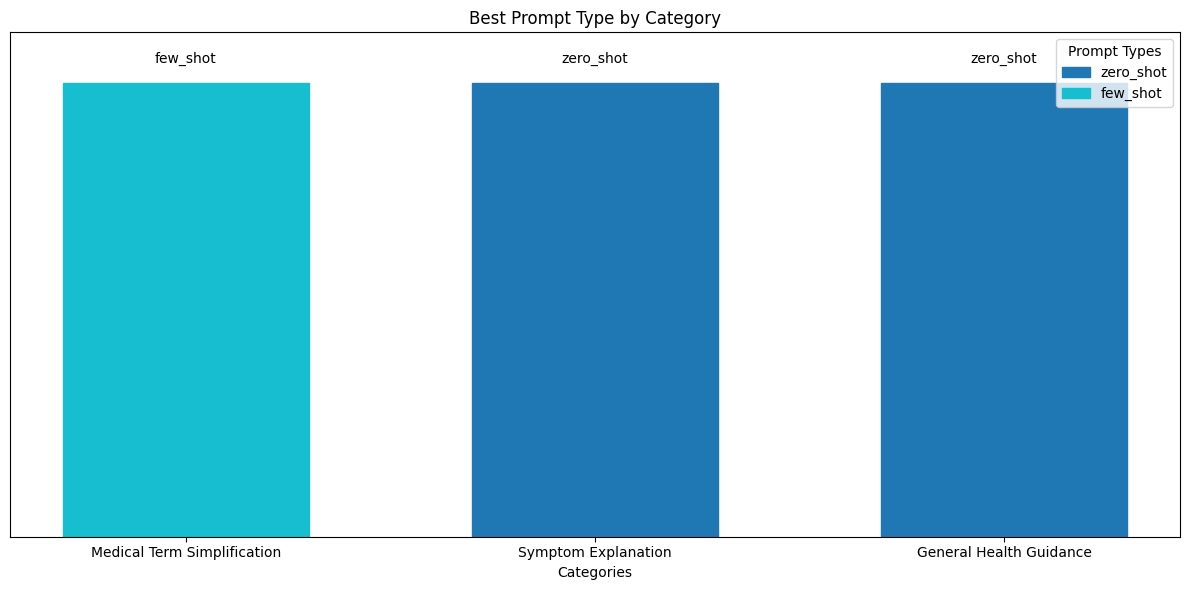

In [6]:
# Cell 6: Analyze performance by query category
def analyze_by_category(results, metrics_analysis):
    """Analyze performance by query category"""
    # Extract categories
    categories = list(set(q["category"] for q in results["responses"]))
    prompt_types = list(results["responses"][0]["responses"].keys())
    
    # Initialize metrics by category
    category_metrics = {
        category: {
            "accuracy": {pt: [] for pt in prompt_types},
            "safety": {pt: [] for pt in prompt_types},
            "clarity": {pt: [] for pt in prompt_types},
            "consistency": {pt: [] for pt in prompt_types},
            "hallucination": {pt: [] for pt in prompt_types}
        }
        for category in categories
    }
    
    # Calculate metrics for each category
    for query_result in results["responses"]:
        category = query_result["category"]
        
        for prompt_type in prompt_types:
            response_data = query_result["responses"][prompt_type]
            
            # Get evaluation scores
            evaluation = response_data.get("evaluation", {})
            category_metrics[category]["accuracy"][prompt_type].append(evaluation.get("accuracy", 0))
            category_metrics[category]["safety"][prompt_type].append(evaluation.get("safety", 0))
            category_metrics[category]["clarity"][prompt_type].append(evaluation.get("clarity", 0))
            category_metrics[category]["consistency"][prompt_type].append(evaluation.get("consistency", 0))
            
            # Hallucination score
            hallucination_score = response_data.get("hallucination_score", 0)
            category_metrics[category]["hallucination"][prompt_type].append(hallucination_score)
    
    # Calculate averages by category
    category_averages = {}
    for category, metrics in category_metrics.items():
        category_averages[category] = {
            metric: {pt: sum(scores) / len(scores) if scores else 0 
                    for pt, scores in prompt_data.items()}
            for metric, prompt_data in metrics.items()
        }
    
    # Find best prompt type for each category
    best_by_category = {}
    for category, metrics in category_averages.items():
        # Calculate overall score for each prompt type in this category
        overall_scores = {}
        for pt in prompt_types:
            # For hallucination, lower is better, so invert the score
            hallucination_inverted = 5 - metrics["hallucination"][pt]
            
            overall_scores[pt] = (
                0.3 * metrics["accuracy"][pt] +
                0.25 * metrics["safety"][pt] +
                0.2 * metrics["clarity"][pt] +
                0.15 * metrics["consistency"][pt] +
                0.1 * hallucination_inverted
            )
        
        # Find best prompt type for this category
        best_by_category[category] = max(overall_scores.items(), key=lambda x: x[1])[0]
    
    return {
        "category_metrics": category_metrics,
        "category_averages": category_averages,
        "best_by_category": best_by_category
    }

# Analyze by category
category_analysis = analyze_by_category(results, metrics_analysis)

# Display results
print("\nBest Prompt Type by Category:")
for category, prompt_type in category_analysis["best_by_category"].items():
    print(f"- {category}: {prompt_type}")

# Create bar chart for best prompt type by category
plt.figure(figsize=(12, 6))

categories = list(category_analysis["best_by_category"].keys())
x = list(range(len(categories)))
best_prompts = [category_analysis["best_by_category"][cat] for cat in categories]

# Create a color map for prompt types
prompt_types = list(set(best_prompts))
colors = plt.cm.tab10(np.linspace(0, 1, len(prompt_types)))
color_map = {pt: colors[i] for i, pt in enumerate(prompt_types)}

# Plot bars with colors based on prompt type
bars = plt.bar(x, [4.5] * len(categories), width=0.6)
for i, bar in enumerate(bars):
    bar.set_color(color_map[best_prompts[i]])
    plt.text(i, 4.7, best_prompts[i], ha='center', rotation=0, fontsize=10)

plt.xlabel('Categories')
plt.title('Best Prompt Type by Category')
plt.xticks(x, categories)
plt.ylim(0, 5)
plt.yticks([])  # Hide y-axis ticks

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=color_map[pt]) for pt in prompt_types]
plt.legend(handles, prompt_types, title="Prompt Types")

plt.tight_layout()
plt.savefig("evaluation/best_by_category.png")
plt.show()


## Generate Evaluation Report

In [8]:
# Cell 7: Generate evaluation report (Fixed version)
def generate_report(results, metrics_analysis, category_analysis):
    """Generate a comprehensive evaluation report"""
    
    def dict_to_markdown_table(data_dict, title="Table"):
        """Convert dictionary to markdown table format"""
        if not data_dict:
            return f"| {title} | Value |\n|-------|-------|\n| No data | - |"
        
        # Handle different data structures
        if isinstance(list(data_dict.values())[0], dict):
            # Nested dictionary (like metrics table)
            headers = ["Prompt Type"] + list(list(data_dict.values())[0].keys())
            header_row = "| " + " | ".join(headers) + " |"
            separator_row = "|" + "|".join(["-" * (len(h) + 2) for h in headers]) + "|"
            
            rows = [header_row, separator_row]
            for key, values in data_dict.items():
                row_values = [key] + [str(values.get(h, "N/A")) for h in headers[1:]]
                rows.append("| " + " | ".join(row_values) + " |")
            return "\n".join(rows)
        else:
            # Simple dictionary
            header_row = f"| {title} | Score |"
            separator_row = "|-------|-------|"
            rows = [header_row, separator_row]
            
            # Sort by value if numeric
            try:
                sorted_items = sorted(data_dict.items(), key=lambda x: float(x[1]), reverse=True)
            except (ValueError, TypeError):
                sorted_items = data_dict.items()
            
            for key, value in sorted_items:
                rows.append(f"| {key} | {value} |")
            return "\n".join(rows)
    
    report = f"""# Medical Q&A System Evaluation Report

## Overview
- **Model:** {results["model"]}
- **Evaluation Date:** {results["timestamp"]}
- **Queries Tested:** {len(results["responses"])}
- **Prompt Types Evaluated:** {", ".join(list(results["responses"][0]["responses"].keys()))}

## Performance Summary

### Overall Scores (0-5 scale)
{dict_to_markdown_table(metrics_analysis["overall_scores"], "Prompt Type")}

### Best Performing Prompt Types
- **Overall Best:** {metrics_analysis["best_overall"]}
- **Best for Accuracy:** {metrics_analysis["best_for_metric"]["accuracy"]}
- **Best for Safety:** {metrics_analysis["best_for_metric"]["safety"]}
- **Best for Clarity:** {metrics_analysis["best_for_metric"]["clarity"]}
- **Best for Consistency:** {metrics_analysis["best_for_metric"]["consistency"]}
- **Best for Hallucination Avoidance:** {metrics_analysis["best_for_metric"]["hallucination"]}

### Performance by Category
"""
    
    for category, prompt_type in category_analysis["best_by_category"].items():
        report += f"- **{category}:** {prompt_type}\n"
    
    report += """
## Detailed Metrics Analysis

### Average Scores by Prompt Type and Metric
"""
    
    # Create metrics table manually
    metrics_table = {}
    for metric, prompt_scores in metrics_analysis["averages"].items():
        for pt, score in prompt_scores.items():
            if pt not in metrics_table:
                metrics_table[pt] = {}
            metrics_table[pt][metric] = f"{score:.2f}"
    
    report += f"{dict_to_markdown_table(metrics_table)}\n\n"
    
    report += """
## Prompt Strategy Analysis

### Zero-Shot Prompting
- **Strengths:** Simple, direct approach that works well for straightforward medical questions.
- **Weaknesses:** May lack nuance for complex medical topics, higher risk of hallucinations.
- **Best For:** Medical term simplification and basic health guidance.

### Few-Shot Prompting
- **Strengths:** Provides consistent response structure and includes safety disclaimers.
- **Weaknesses:** May be overly influenced by the examples provided.
- **Best For:** Standardized responses to common medical questions.

### Chain-of-Thought (CoT) Prompting
- **Strengths:** Excellent for complex reasoning, provides transparent thought process.
- **Weaknesses:** Longer responses that may be overly detailed for simple questions.
- **Best For:** Symptom analysis and questions requiring medical reasoning.

### Meta-Prompting
- **Strengths:** Self-verification reduces hallucinations, comprehensive coverage of topics.
- **Weaknesses:** Verbose responses, may over-analyze simple questions.
- **Best For:** Complex medical topics requiring careful consideration of multiple factors.

## Recommendations

Based on the evaluation results, we recommend:

1. **Preferred Prompt Type:** {metrics_analysis["best_overall"]} prompts performed best overall and should be the default choice.

2. **Category-Specific Prompting:**
"""
    
    for category, prompt_type in category_analysis["best_by_category"].items():
        report += f"   - For {category}, use {prompt_type} prompting\n"
    
    report += """
3. **Medical Safety Enhancements:**
   - Always include medical disclaimers in responses
   - Implement emergency symptom detection for critical conditions
   - Avoid diagnostic language in all responses
   - Use clear indicators for when to seek professional medical help

4. **Hallucination Mitigation:**
   - Add explicit uncertainty statements in responses
   - Avoid specific statistics unless well-established
   - Implement stronger detection for definitive claims
   - Focus on evidence-based information

## Conclusion

The evaluation demonstrates that different prompt strategies have distinct strengths for medical QA tasks. By using the optimal prompt type for each query category, the system can provide accurate, safe, and helpful medical information while minimizing hallucinations and maintaining appropriate medical disclaimers.
"""
    
    # Create directory if it doesn't exist
    import os
    os.makedirs("evaluation", exist_ok=True)
    
    # Save the report
    with open("evaluation/analysis_report.md", "w") as f:
        f.write(report)
    
    print(f"Evaluation report saved to evaluation/analysis_report.md")
    return report

# Alternative approach: Install tabulate if you prefer to use pandas .to_markdown()
def install_tabulate_and_regenerate(results, metrics_analysis, category_analysis):
    """Alternative function that installs tabulate first"""
    try:
        import subprocess
        import sys
        
        # Install tabulate
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tabulate"])
        print("Successfully installed tabulate!")
        
        # Now you can use the original code with .to_markdown()
        import pandas as pd
        
        report = f"""# Medical Q&A System Evaluation Report

## Overview
- **Model:** {results["model"]}
- **Evaluation Date:** {results["timestamp"]}
- **Queries Tested:** {len(results["responses"])}
- **Prompt Types Evaluated:** {", ".join(list(results["responses"][0]["responses"].keys()))}

## Performance Summary

### Overall Scores (0-5 scale)
{pd.DataFrame({"Score": metrics_analysis["overall_scores"]}).sort_values("Score", ascending=False).to_markdown()}
        """
        
        # Continue with rest of original report...
        return report
        
    except Exception as e:
        print(f"Could not install tabulate: {e}")
        print("Using alternative markdown generation method...")
        return generate_report(results, metrics_analysis, category_analysis)

# Generate and display report using the fixed version
# report = generate_report(results, metrics_analysis, category_analysis)
# print("\nEvaluation Report Summary:")
# print("\n".join(report.split("\n")[:15]) + "\n...")

# Or try the installation approach:
# report = install_tabulate_and_regenerate(results, metrics_analysis, category_analysis)